# House Prices - Advanced Regression Techniques

#### This colab notebook contains the code for approaching the famous basic Kaggle contest "House Prices - Advanced Regression Techniques".

I will use this dataset with three different models(linear model, tree-based model, neural network model). I will save them and create 


1.   Downloading the data
2.   Splitting the data
3.   EDA, Data Visualization and Feature Engineering
4.   Basic Linear Regression model
5.   Keras DL model
6.   Tree-based model
8.   Report geneeration for all the models



## Importing libraries


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.base import BaseEstimator
from numpy import log1p as log

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf

## Loading the datasets


In [ ]:
Data = pd.read_csv('data/Data.csv')
train_ds,test_ds = train_test_split(Data,test_size=0.2)

We have nearly similar datapoints in training and test datasets. The test dataset has one column less than train dataset because we need to predict the last column.

In [ ]:
print(train_ds.shape)
print(test_ds.shape)

(1168, 81)
(292, 81)


In [ ]:
train_ds.head()

        Id  MSSubClass MSZoning  ...  SaleType  SaleCondition SalePrice
1385  1386          50       RM  ...        WD         Normal    125500
902    903          60       RL  ...        WD         Normal    180000
328    329          75       RL  ...        WD         Normal    214500
422    423          20       RL  ...        WD         Normal    113000
936    937          20       RL  ...        WD         Normal    184900

[5 rows x 81 columns]


## EDA and Data Preprocessing


### Analyzing missing values

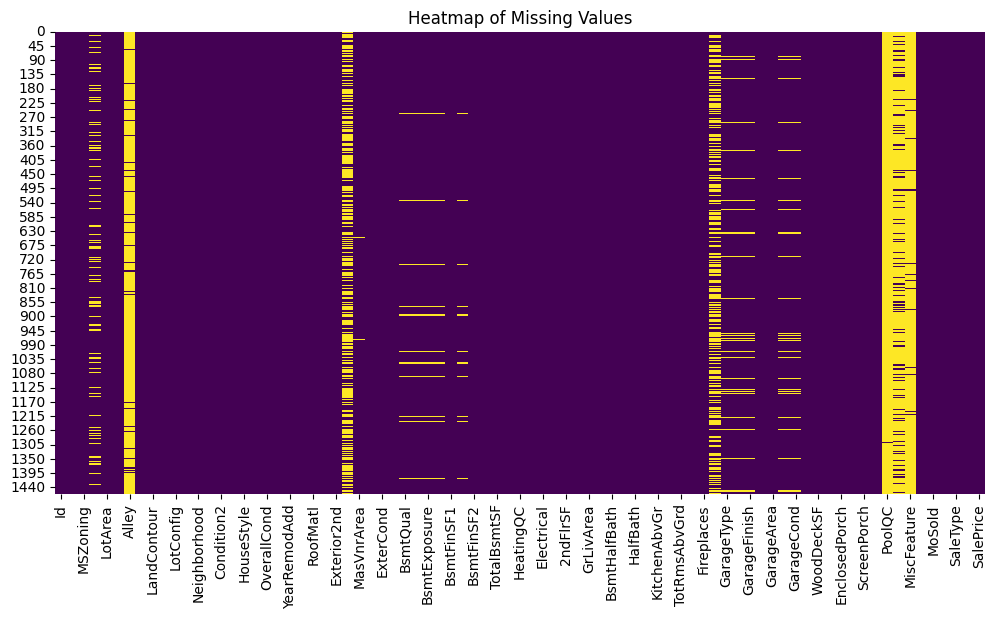

In [ ]:
# Checking for missing values
missing_values = train_ds.isnull().sum().sort_values(ascending=False)
missing_percentage = (train_ds.isnull().sum() / train_ds.shape[0]).sort_values(ascending=False)
missing_df = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})

# Visualizing missing data with a heatmap
# Just for reference. Don't make much sense due to number of features
plt.figure(figsize=(12, 6))
sns.heatmap(train_ds.isnull(), cmap='viridis', cbar=False)
plt.title('Heatmap of Missing Values')
plt.show()


In [ ]:
missing_df.head(20)

              Missing Values  Percentage
PoolQC                  1162    0.994863
MiscFeature             1122    0.960616
Alley                   1094    0.936644
Fence                    939    0.803938
MasVnrType               702    0.601027
FireplaceQu              547    0.468322
LotFrontage              205    0.175514
GarageYrBlt               66    0.056507
GarageCond                66    0.056507
GarageType                66    0.056507
GarageFinish              66    0.056507
GarageQual                66    0.056507
BsmtFinType2              31    0.026541
BsmtExposure              31    0.026541
BsmtQual                  30    0.025685
BsmtCond                  30    0.025685
BsmtFinType1              30    0.025685
MasVnrArea                 6    0.005137
Electrical                 1    0.000856
Id                         0    0.000000


Dropping columns with missing values > 50%

In [ ]:
columns_to_drop = ['PoolQC', 'MiscFeature', 'Alley', 'Fence','Id']
train_ds.drop(columns=columns_to_drop, axis=1, inplace=True)
test_ds.drop(columns=columns_to_drop, axis=1, inplace=True)


Columns with missing values between 5% and 50%

In [ ]:
# Impute missing categorical values with mode
categorical_cols = ['MasVnrType', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
                    'BsmtFinType2', 'BsmtExposure', 'BsmtQual', 'BsmtCond', 'BsmtFinType1']
for col in categorical_cols:
    train_ds[col].fillna(train_ds[col].mode()[0], inplace=True)
    test_ds[col].fillna(test_ds[col].mode()[0], inplace=True)

# Impute missing numerical values with median (to avoid influence of outliers)
numerical_cols = ['LotFrontage', 'GarageYrBlt', 'MasVnrArea']
for col in numerical_cols:
    train_ds[col].fillna(train_ds[col].median(), inplace=True)
    test_ds[col].fillna(test_ds[col].median(), inplace=True)



Columns with missing values < 5%

In [ ]:
# Impute missing Electrical column with mode
train_ds['Electrical'].fillna(train_ds['Electrical'].mode()[0], inplace=True)
test_ds['Electrical'].fillna(test_ds['Electrical'].mode()[0], inplace=True)

Features related to the garage (GarageType, GarageCond, etc.) and basement (BsmtFinType1, BsmtCond, etc.) have multiple columns with the same number of missing values. This is likely because some houses don’t have a garage or basement.

In [ ]:
# Impute missing Garage features
garage_cols = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
for col in garage_cols:
    train_ds[col].fillna('None', inplace=True)
    test_ds[col].fillna('None', inplace=True)

train_ds['GarageYrBlt'].fillna(0, inplace=True)
test_ds['GarageYrBlt'].fillna(0, inplace=True)

# Impute missing Basement features
bsmt_cols = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
for col in bsmt_cols:
    train_ds[col].fillna('None', inplace=True)
    test_ds[col].fillna('None', inplace=True)


### Data visualization

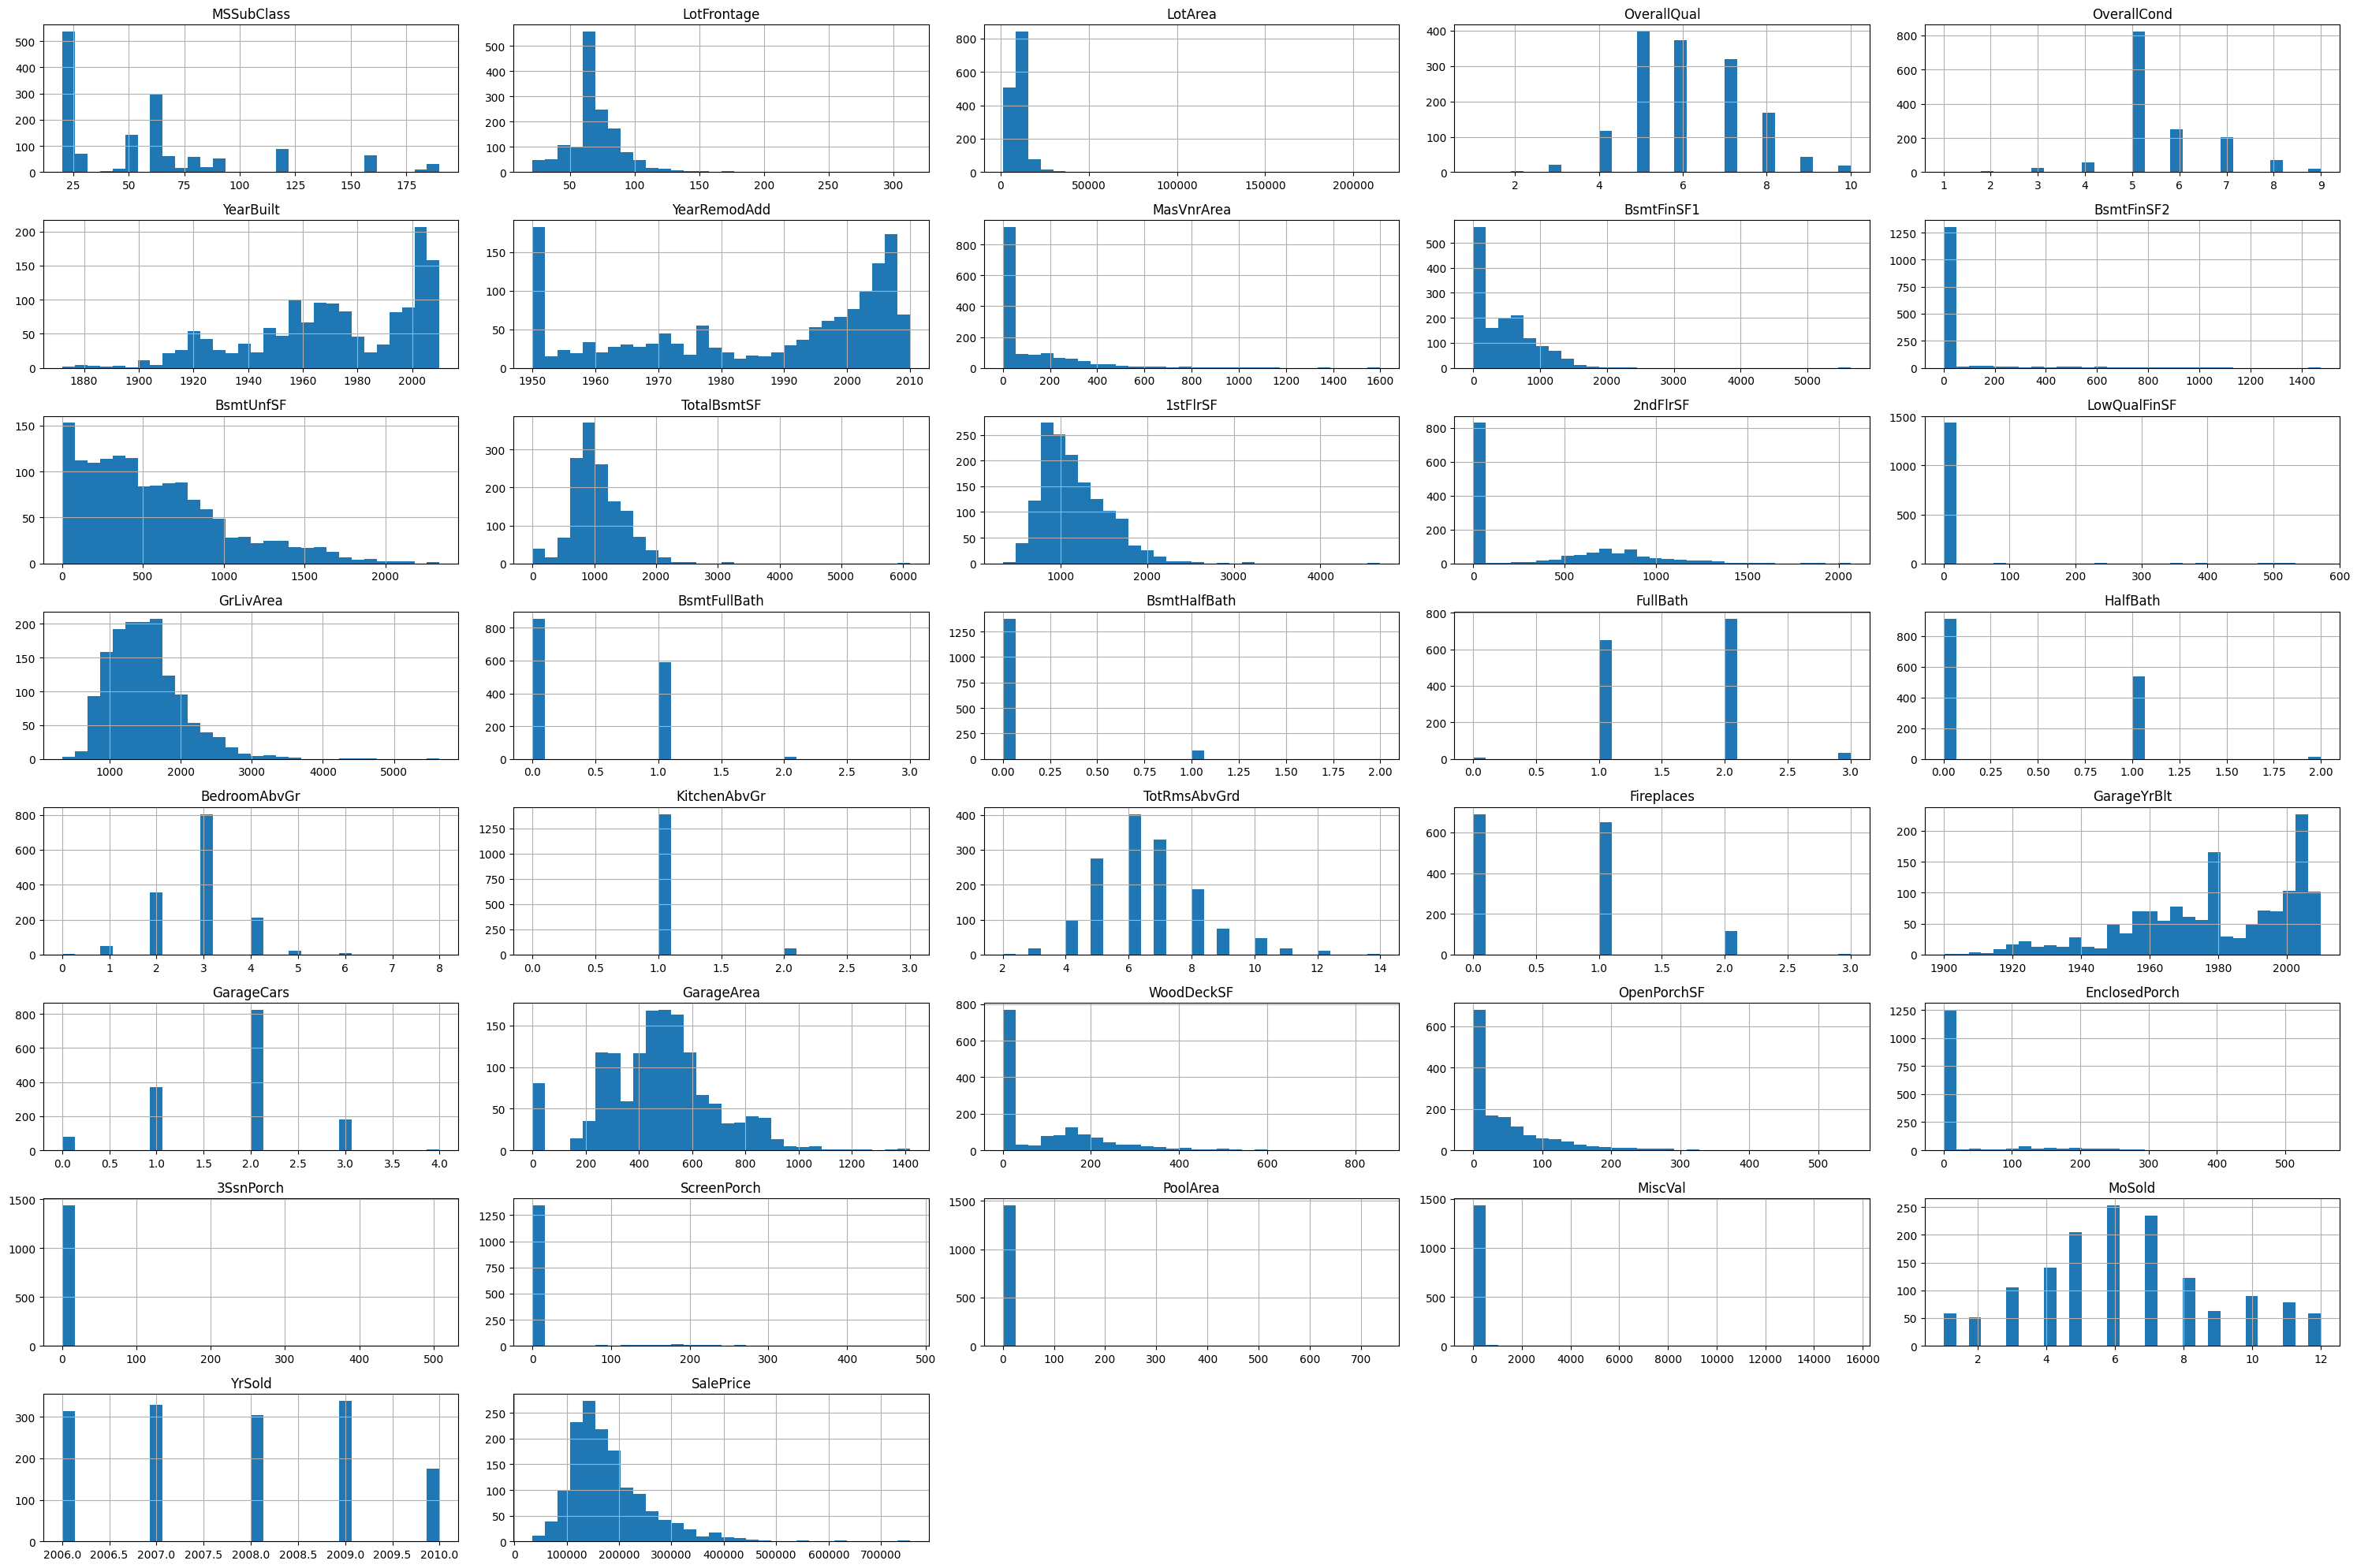

In [ ]:
# Distribution of numeric features
import math

# Get all numeric columns
numeric_columns = train_ds.select_dtypes(include=['float64', 'int64']).columns

# Set up the grid layout (you can change rows and cols based on the number of features)
n_cols = 5  # Number of columns for the grid
n_rows = math.ceil(len(numeric_columns) / n_cols)  # Calculate required rows

# Create subplots with the determined grid size
fig, axes = plt.subplots(n_rows, n_cols, figsize=(30, 20))  # Adjust figsize as needed
axes = axes.flatten()  # Flatten the axes for easy iteration

# Plot each numeric column
for idx, col in enumerate(numeric_columns):
    train_ds[col].hist(bins=30, ax=axes[idx])
    axes[idx].set_title(col)

# Hide any empty subplots (if any)
for i in range(len(numeric_columns), len(axes)):
    fig.delaxes(axes[i])

# Adjust layout
plt.tight_layout()
plt.show()


The SalePrice variable in the last plot looks right skewed. Lets visualise the logarithm of the plot.

In [ ]:
np.log1p(train_ds['SalePrice']).hist(bins=30)

Axes(0.125,0.11;0.775x0.77)


The log plot looks more like a normally distributed value. We will try to train with log of outputs as training with normally distributed features geberally provide better results.

In [ ]:
def preprocess_data(df):

  for i in df.columns:

    if df[i].dtype == 'object' or (df[i].dtype in ['int64'] and df[i].nunique() < 10): # Categorical Data
      df[i] = df[i].astype('category')
      df[i] = df[i].cat.codes
      df[i].fillna(df[i].mode()[0], inplace=True)

    elif df[i].dtype in ['int64', 'float64']:
      df[i].fillna(df[i].median(), inplace=True)
  return df


In [ ]:
numeric_df = train_ds.copy()
numeric_df = preprocess_data(numeric_df)
corr_target = numeric_df.corr()['SalePrice'].sort_values(ascending=False)
print(corr_target.array)

<NumpyExtensionArray>
[                  np.float64(1.0),    np.float64(0.7903744469772146),
    np.float64(0.7030069743577321),    np.float64(0.6422804626449353),
    np.float64(0.6161348988366137),     np.float64(0.606356770953013),
    np.float64(0.6049460171171477),    np.float64(0.5575687340976256),
    np.float64(0.5153162080526716),    np.float64(0.5148028219771522),
    np.float64(0.5043883930358964),    np.float64(0.4640288781657106),
    np.float64(0.4555404864221014),    np.float64(0.4554173353322824),
    np.float64(0.3764774181514811),   np.float64(0.37401626193761334),
   np.float64(0.33174314139616273),   np.float64(0.32169418816440837),
    np.float64(0.3184283313371658),    np.float64(0.3154784606199909),
    np.float64(0.3091792237419474),    np.float64(0.2738935119421121),
   np.float64(0.27188690048917974),   np.float64(0.24686434644544264),
   np.float64(0.23319122165347778),   np.float64(0.22426253713920616),
   np.float64(0.22032718912045274),   np.float64(0.2199

In [ ]:
# Select top 10 positively and top 10 negatively correlated features for SalePrice
top_corr = corr_target.head(10).index.tolist()
low_corr = corr_target.tail(10).index.tolist()


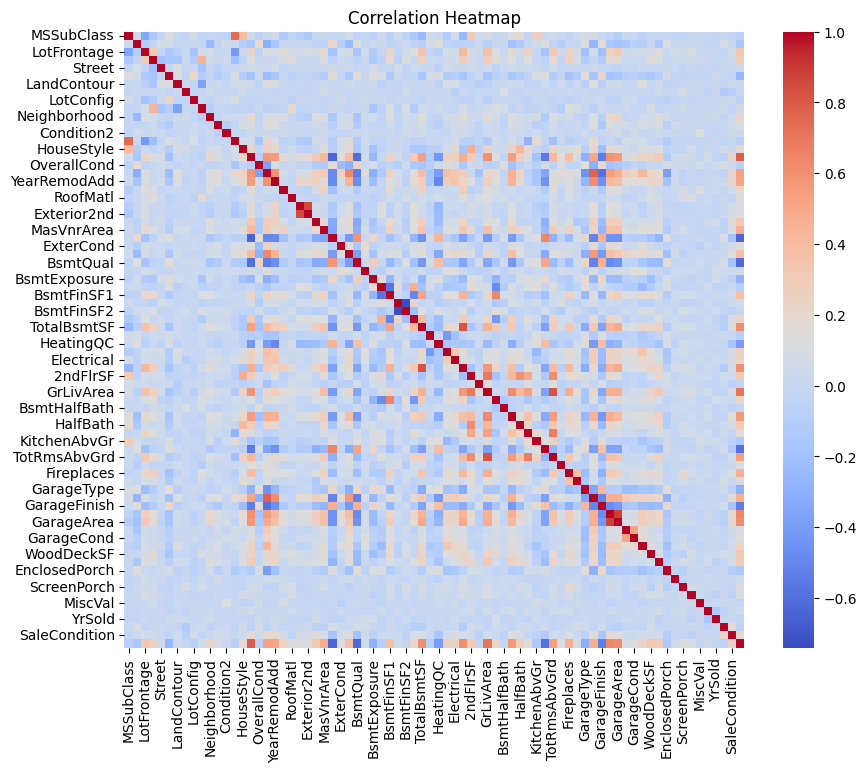

In [ ]:
# Heatmap of correlations
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_df.corr(), annot=False, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()


We can already see some highly correlated features. We will be dropping them to avoid performance impact due to multicollinearity.

### Preprocessing Data

Converting categorical data into numeric form and normalizing the numeric data for data consistency.

In [ ]:
preprocess_data(train_ds)
preprocess_data(test_ds)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,2,80.0,11622,1,3,3,0,4,0,...,0,0,0,120,0,0,6,4,8,4
1,20,3,81.0,14267,1,0,3,0,0,0,...,36,0,0,0,0,12500,6,4,8,4
2,60,3,74.0,13830,1,0,3,0,4,0,...,34,0,0,0,0,0,3,4,8,4
3,60,3,78.0,9978,1,0,3,0,4,0,...,36,0,0,0,0,0,6,4,8,4
4,120,3,43.0,5005,1,0,1,0,4,0,...,82,0,0,144,0,0,1,4,8,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,160,4,21.0,1936,1,3,3,0,4,0,...,0,0,0,0,0,0,6,0,8,4
1455,160,4,21.0,1894,1,3,3,0,4,0,...,24,0,0,0,0,0,4,0,8,0
1456,20,3,160.0,20000,1,3,3,0,4,0,...,0,0,0,0,0,0,9,0,8,0
1457,85,3,62.0,10441,1,3,3,0,4,0,...,32,0,0,0,0,700,7,0,8,4


In [ ]:
xTrain = train_ds.iloc[:, :-1]
yTrain = train_ds.iloc[:, -1]

Correlation matrix for input features

In [ ]:
correlation_matrix = xTrain.corr()

correlated_features = []
for i in range(len(correlation_matrix.columns)):
  for j in range(i + 1, len(correlation_matrix.columns)):  # Avoid duplicates and self-correlation
    if abs(correlation_matrix.iloc[i, j]) >= 0.7:
      correlated_features.append((correlation_matrix.columns[i], correlation_matrix.columns[j], correlation_matrix.iloc[i, j]))

correlated_features


[('MSSubClass', 'BldgType', 0.7460629359877902),
 ('YearBuilt', 'GarageYrBlt', 0.7771817647425319),
 ('Exterior1st', 'Exterior2nd', 0.8541629837325787),
 ('BsmtFinType2', 'BsmtFinSF2', -0.7399122539827684),
 ('TotalBsmtSF', '1stFlrSF', 0.8195299750050339),
 ('GrLivArea', 'TotRmsAbvGrd', 0.8254893743088425),
 ('GarageCars', 'GarageArea', 0.882475414281462)]

We can drop one of the highly correlated features to avoid performance drop due to multicollinearity.

In [ ]:
features_to_drop = [i[1] for i in correlated_features]
xTrain = xTrain.drop(columns=features_to_drop)
test_df = test_ds.drop(columns=features_to_drop)

## Model Training

In [ ]:
xTrain, xValid, yTrain, yValid = train_test_split(xTrain, yTrain, test_size=0.2, random_state=42)

Linear model

In [ ]:
model_linear = LinearRegression()

# Train the pipeline on the training data
model_linear.fit(xTrain, np.log1p(yTrain))

# Make predictions on the validation data
y_pred = model_linear.predict(xValid)

# Evaluate the model_deep's performance (using RMSE here)
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error((yValid), np.expm1(y_pred)))
print(f'Root Mean Squared Error: {rmse}')

Root Mean Squared Error: 124534.7368439503


In [ ]:

# create an iterator object with write permission - model.pkl
with open('models/model_linear_pkl.pkl', 'wb') as files:
    pickle.dump(model_linear, files)

Tree based model

In [ ]:
random_forest_model = RandomForestRegressor()
random_forest_model.fit(xTrain, yTrain)

# Make predictions on the validation data
y_pred_rand_forest = random_forest_model.predict(xValid)

# Evaluate the model's performance (using RMSE here)
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(yValid, y_pred_rand_forest))
print(f'Root Mean Squared Error: {rmse}')


Root Mean Squared Error: 33112.68621190123


In [ ]:
# create an iterator object with write permission - model.pkl
with open('models/model_tree_pkl.pkl', 'wb') as files:
    pickle.dump(random_forest_model, files)

Defining a custom tensorflow model within an sklearn compatible class

In [ ]:
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential

model_deep = Sequential()
model_deep.add(Dense(64, activation='relu', input_shape=(xTrain.shape[1],)))
model_deep.add(BatchNormalization())  # Batch normalization
model_deep.add(Dropout(0.2))  # Dropout layer
model_deep.add(Dense(32, activation='relu'))
model_deep.add(BatchNormalization())  # Batch normalization
model_deep.add(Dropout(0.3))  # Dropout layer
model_deep.add(Dense(1) )  # Output layer

model_deep.compile(optimizer='adam', loss='mse')

# Fit the pipeline to the training data
model_deep.fit(xTrain, log(yTrain), epochs = 200)

# Make predictions on the validation data
y_pred_tf = model_deep.predict(xValid)

# Evaluate the model's performance (using RMSE here)
rmse = np.sqrt(mean_squared_error(yValid, np.expm1(y_pred_tf)))
print(f'Root Mean Squared Error: {rmse}')



Epoch 1/200

 1/30 ━━━━━━━━━━━━━━━━━━━━ 13s 453ms/step - loss: 143.8584
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step - loss: 144.3976 
Epoch 2/200

 1/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 139.2545
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 659us/step - loss: 139.7844
Epoch 3/200

 1/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 140.4891
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step - loss: 134.9126
Epoch 4/200

 1/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 130.1296
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step - loss: 130.1350
Epoch 5/200

 1/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 119.9898
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 621us/step - loss: 120.1911
Epoch 6/200

 1/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 114.3310


The deep learning model is not performing well. It can be due to less data and network structure. 

In [ ]:
model_deep.save('models/model_deep.keras')

xgboost model

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [ ]:
xgb_reg_grid = xgb.XGBRegressor(n_estimators=215,
                                learning_rate=0.057,
                           colsample_bytree=0.7,
                           max_depth=4,
                           reg_lambda=0.2,
                           subsample=0.6,
                           objective='reg:squarederror')

xgb_reg_grid.fit(xTrain, log(yTrain))

# Make predictions
y_pred_xgb = xgb_reg_grid.predict(xValid)

# Evaluate RMSE
rmse_xgb = np.sqrt(mean_squared_error(yValid, np.expm1(y_pred_xgb)))
print(f"XGBoost RMSE: {rmse_xgb}")

XGBoost RMSE: 23835.200859233388


In [ ]:
# create an iterator object with write permission - model.pkl
with open('models/model_xgboost_tree_pkl.pkl', 'wb') as files:
    pickle.dump(xgb_reg_grid, files)

Got the best results with xgBoost. Let's run the model on test set. 

In [ ]:
testX = test_df.iloc[:, :-1]
testY = test_df.iloc[:,-1]

In [ ]:
testX.to_csv("data/Shap_data.csv", index = False)

In [ ]:
y_pred = xgb_reg_grid.predict(testX)
print(np.sqrt(mean_squared_error(testY, np.expm1(y_pred))))

24510.958202404083


We got an RMSE of 24510 on test set. 
We have saved four models for report generation
1. Linear model
2. Random forest model
3. Neural network
4. xgBoost model

We will be using the ReportGeneration.ipynb file for report generation of these models. 